<a href="https://colab.research.google.com/github/maurotangari/deeplearning/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, 5)]            0         []                            
                                                                                                  
 self_attention_8 (SelfAtte  (None, None, 512)            7680      ['input_5[0][0]']             
 ntion)                                                                                           
                                                                                                  
 dense_20 (Dense)            (None, None, 128)            65664     ['self_attention_8[0][0]']    
                                                                                                  
 dense_21 (Dense)            (None, None, 128)            16512     ['dense_20[0][0]']      

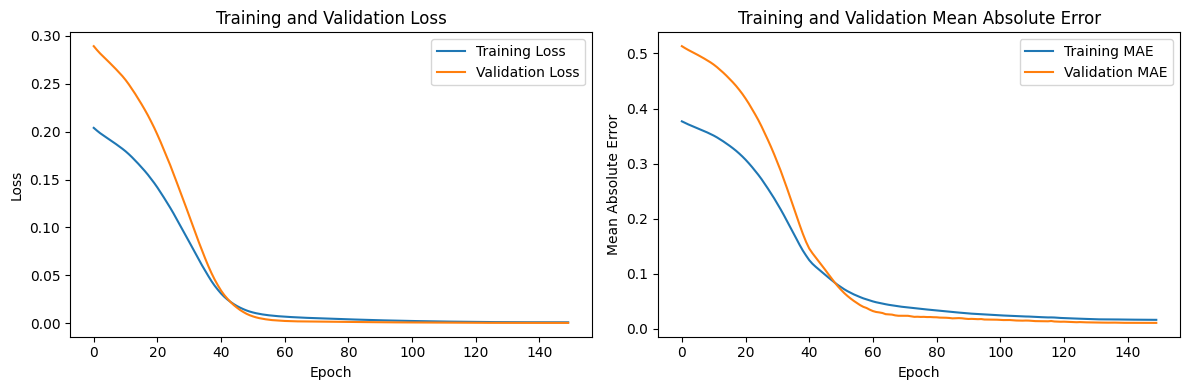

Best Validation Loss: 0.0002 at epoch 150
Best Training Loss: 0.0008 at epoch 150


<Figure size 1200x2400 with 0 Axes>

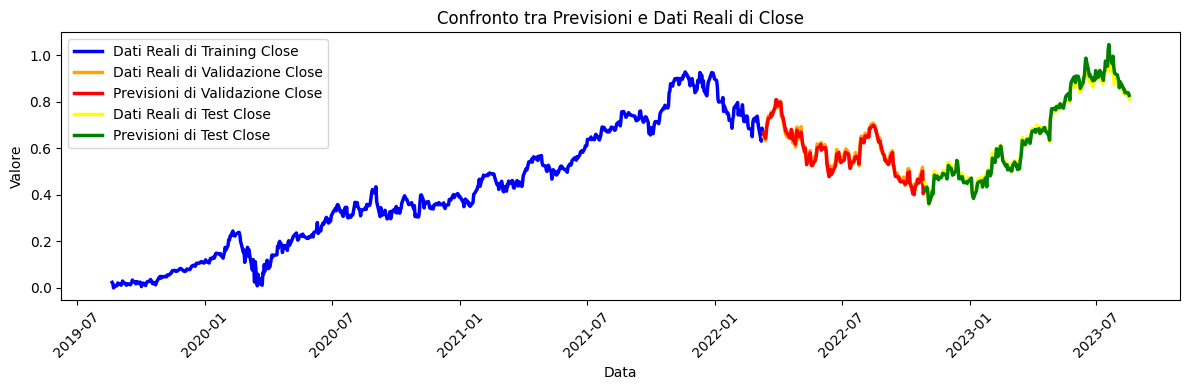

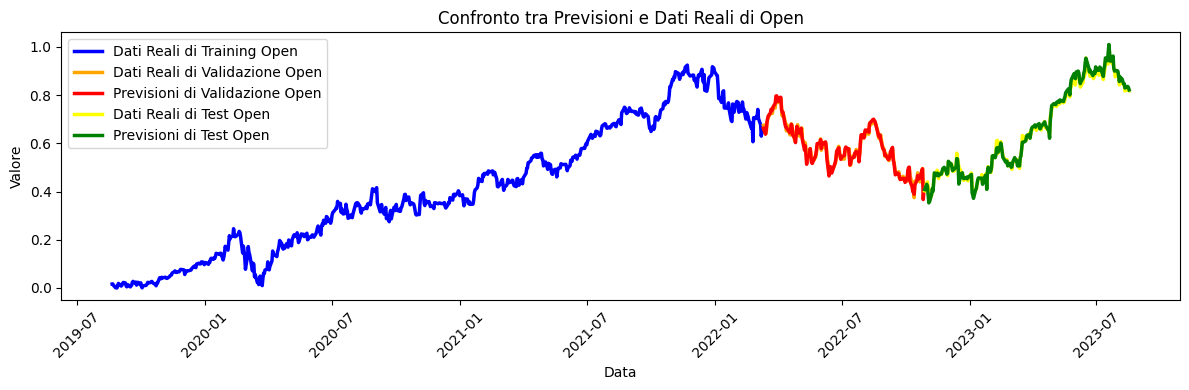

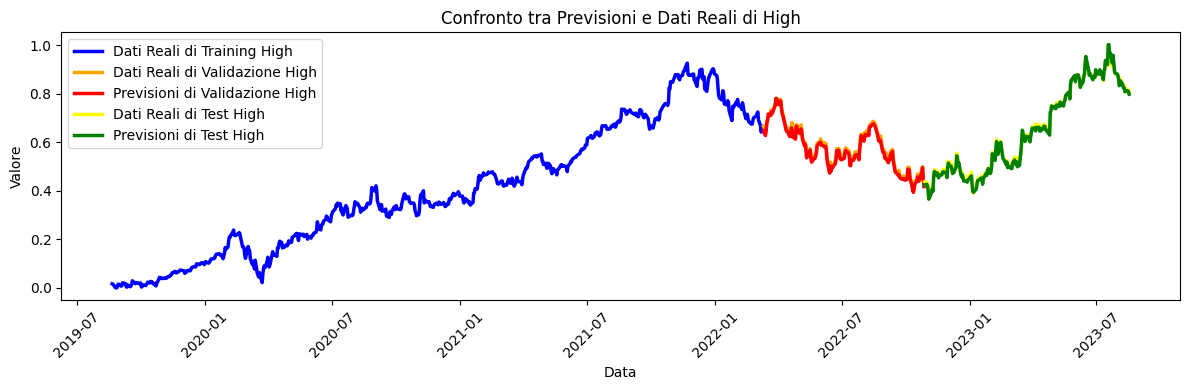

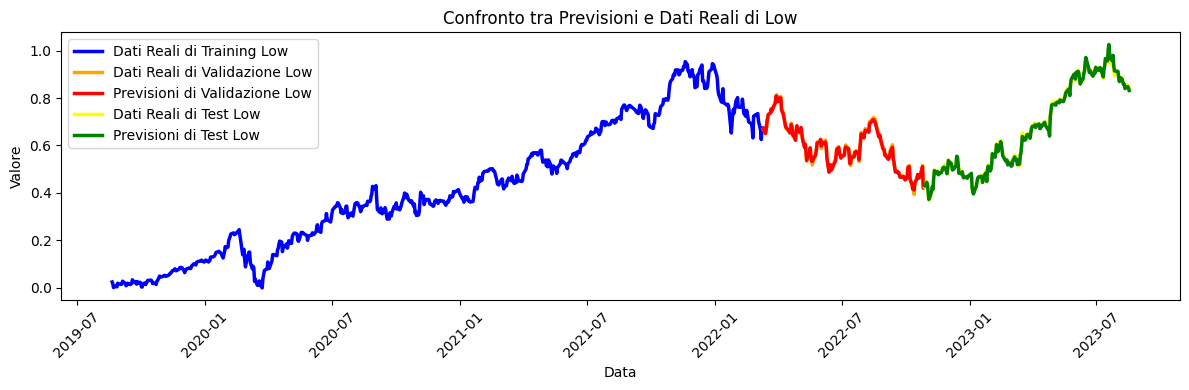

     Actual Close  Actual Open  Actual High  Actual Low  Actual Volume
0        0.648740     0.674748     0.665816    0.668016       0.206991
1        0.632685     0.641160     0.648041    0.651601       0.246201
2        0.680053     0.641204     0.658507    0.664833       0.286922
3        0.712074     0.679817     0.687700    0.685158       0.327607
4        0.715745     0.698241     0.692198    0.713214       0.247972
..            ...          ...          ...         ...            ...
155      0.480893     0.440164     0.464666    0.463714       0.196658
156      0.503583     0.479922     0.485598    0.494634       0.180884
157      0.518664     0.495350     0.499438    0.515233       0.292948
158      0.433127     0.424428     0.444339    0.443525       0.835618
159      0.412915     0.423855     0.424401    0.424063       0.357125

[160 rows x 5 columns]
     Prediction Close  Prediction Open  Prediction High  Prediction Low  \
0            0.665786         0.662394         0.

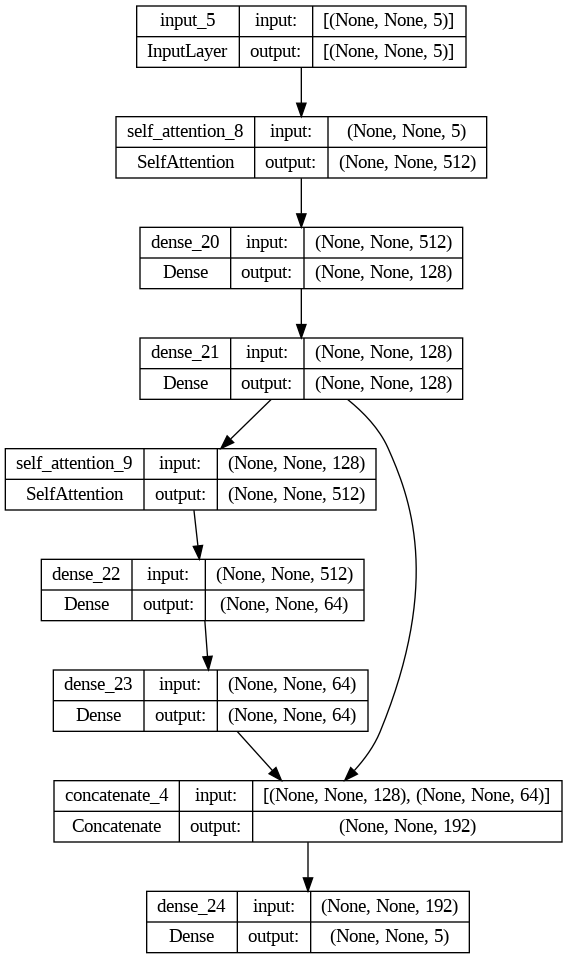

In [ ]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Concatenate, Input, Dense, Dropout, Layer, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import GlobalAveragePooling1D
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Definizione della funzione per convertire una stringa in un oggetto datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

# Caricamento dei dati dai file CSV
#df = pd.read_csv('AAPL.csv')
#df = pd.read_csv('AMZN.csv')
#df = pd.read_csv('GOOG.csv')
df = pd.read_csv('MSFT.csv')

# Selezione delle colonne di interesse (Date, Close, Open, High, Low, Volume)
df = df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']]

# Conversione delle date da stringa a oggetti datetime
df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')

# Rimozione delle righe con dati mancanti o nulli
df.dropna(inplace=True)

# Normalizzazione dei dati utilizzando la tecnica Min-Max
scaler = MinMaxScaler()
df[['Close', 'Open', 'High', 'Low', 'Volume']] = scaler.fit_transform(df[['Close', 'Open', 'High', 'Low', 'Volume']])

# Creazione di input (X) e target (y) dai dati
X = df[['Close', 'Open', 'High', 'Low', 'Volume']].values
y = df[['Close', 'Open', 'High', 'Low', 'Volume']].values  # Target multi-output

# Calcolo delle dimensioni dei set
train_size = int(len(X) * 0.8)
val_size = int(train_size * 0.2)  # 20% del training set

# Divisione dei dati in set di addestramento, validazione e test
X_train, y_train = X[:train_size - val_size], y[:train_size - val_size]
X_val, y_val = X[train_size - val_size:train_size], y[train_size - val_size:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train_3d = X_train[:, np.newaxis, :]  # (dimensione_train, 1, 5)
X_val_3d = X_val[:, np.newaxis, :]  # (dimensioni_val, 1, 5)
X_test_3d = X_test[:, np.newaxis, :]  # (dimensioni_test, 1, 5)

# Aggiungi una dimensione temporale anche per i target
y_train_3d = y_train[:, np.newaxis, :]
y_val_3d = y_val[:, np.newaxis, :]
y_test_3d = y_test[:, np.newaxis, :]

# Definizione dello strato di Self-Attention
class SelfAttention(Layer):
    def __init__(self, num_heads, head_dim, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.head_dim = head_dim

    def build(self, input_shape):
        self.W_q = self.add_weight("W_q", shape=(input_shape[-1], self.num_heads * self.head_dim))
        self.W_k = self.add_weight("W_k", shape=(input_shape[-1], self.num_heads * self.head_dim))
        self.W_v = self.add_weight("W_v", shape=(input_shape[-1], self.num_heads * self.head_dim))

    def call(self, inputs):
        q = tf.matmul(inputs, self.W_q)
        k = tf.matmul(inputs, self.W_k)
        v = tf.matmul(inputs, self.W_v)

        q = tf.reshape(q, (-1, tf.shape(q)[1], self.num_heads, self.head_dim))
        k = tf.reshape(k, (-1, tf.shape(k)[1], self.num_heads, self.head_dim))
        v = tf.reshape(v, (-1, tf.shape(v)[1], self.num_heads, self.head_dim))

        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)

        output = tf.matmul(attention_scores, v)
        output = tf.reshape(output, (-1, tf.shape(output)[1], self.num_heads * self.head_dim))

        return output

# Dimensioni dei dati
num_features = 5  # Numero di features nel dataset
num_heads = 8     # Numero di teste per l'attenzione multi-head
head_dim = 64     # Dimensione di ogni testa di attenzione

# Creazione del modello Sequential
transformer_model = Sequential()

# Aggiunta degli strati al modello
input_layer = Input(shape=(None, num_features))  # Adatta la forma all'intero dataset

# Primo encoder
encoder_1 = SelfAttention(num_heads=num_heads, head_dim=head_dim)(input_layer)
encoder_1 = Dense(128, activation='relu')(encoder_1)
encoder_1 = Dense(128, activation='relu')(encoder_1)

# Secondo encoder
encoder_2 = SelfAttention(num_heads=num_heads, head_dim=head_dim)(encoder_1)
encoder_2 = Dense(64, activation='relu')(encoder_2)
encoder_2 = Dense(64, activation='relu')(encoder_2)

# Concatena l'output dei due encoder
concatenated_output = Concatenate()([encoder_1, encoder_2])

# Output layer
output_layer = Dense(num_features)(concatenated_output)

# Aggiungi l'output layer al modello
transformer_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)


# Creazione del modello con self-attention e più strati
transformer_model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.00001),
              metrics=['mean_absolute_error'])

# Stampa un riassunto del modello
transformer_model.summary()

# Aggiunta di un callback per ridurre il tasso di apprendimento su plateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, verbose=1, min_lr=1e-6)
callbacks = [lr_scheduler]

history = transformer_model.fit(X_train_3d, y_train_3d, validation_data=(X_val_3d, y_val_3d),
                                      epochs=150,
                                      batch_size=64,
                                      callbacks=callbacks,
                                      verbose=1)


# Creazione delle previsioni sui dati di validazione e test
predictions_val = transformer_model.predict(X_val_3d)
predictions_test = transformer_model.predict(X_test_3d)

# Valuta il modello sull'insieme di test
test_loss, test_mae = transformer_model.evaluate(X_test_3d, y_test_3d, verbose=0)

# Riduci le dimensioni di y_test_3d a (1006, 5)
y_test_2d = y_test_3d.reshape(-1, 5)

# Rimuovi il terzo asse dalle previsioni
predictions_test_squeezed = np.squeeze(predictions_test)

# Calcola il RMSE
rmse = np.sqrt(mean_squared_error(y_test_2d, predictions_test_squeezed))

# Calcola il R-squared (R²)
r2 = r2_score(y_test_2d, predictions_test_squeezed)

print(f'Test Loss: {test_loss}')
print(f'Test Mean Absolute Error (MAE): {test_mae}')
print(f'Test Root Mean Squared Error (RMSE): {rmse}')
print(f'Test R-squared (R²): {r2}')


# Creazione dei grafici delle learning curve
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation Mean Absolute Error')

plt.tight_layout()
plt.show()

# Trova l'indice dell'epoca con la minima val_loss e loss
best_epoch_val = np.argmin(history.history['val_loss'])
best_epoch = np.argmin(history.history['loss'])
# Trova il valore minimo della val_loss e loss
best_val_loss = history.history['val_loss'][best_epoch_val]
best_loss = history.history['loss'][best_epoch]
# Stampa il risultato
print(f'Best Validation Loss: {best_val_loss:.4f} at epoch {best_epoch_val + 1}')
print(f'Best Training Loss: {best_loss:.4f} at epoch {best_epoch + 1}')


feature_names = ['Close', 'Open', 'High', 'Low']  # Escludi la feature 'Volume'

plt.figure(figsize=(12, 24))  # Imposta la dimensione complessiva del grafico

total_train_samples = len(y_train)
total_val_samples = len(y_val)
total_test_samples = len(y_test)


# Estrai le date dei dati di addestramento e validazione
dates_train = df.index[:total_train_samples]
dates_val = df.index[total_train_samples:total_train_samples + total_val_samples]
dates_test = df.index[total_train_samples + total_val_samples:]

# Creazione dei grafici delle previsioni per ciascuna feature
for feature_index, feature_name in enumerate(feature_names):
    plt.figure(figsize=(12, 4))

    # Estrai i dati reali e le previsioni per la caratteristica specifica
    y_train_feature = y_train_3d[:, 0, feature_index]
    y_val_feature = y_val_3d[:, 0, feature_index]
    predictions_val_feature = predictions_val[:, 0, feature_index]
    y_test_feature = y_test_3d[:, 0, feature_index]
    predictions_test_feature = predictions_test[:, 0, feature_index]

    plt.plot(dates_train, y_train_feature, color='blue', label=f'Dati Reali di Training {feature_name}', linewidth=2.5)
    plt.plot(dates_val, y_val_feature, color='orange', label=f'Dati Reali di Validazione {feature_name}', linewidth=2.5)
    plt.plot(dates_val, predictions_val_feature, color='red', label=f'Previsioni di Validazione {feature_name}', linewidth=2.5)
    plt.plot(dates_test, y_test_feature, color='yellow', label=f'Dati Reali di Test {feature_name}', linewidth=2.5)
    plt.plot(dates_test, predictions_test_feature, color='green', label=f'Previsioni di Test {feature_name}', linewidth=2.5)

    plt.xlabel('Data')
    plt.ylabel('Valore')
    plt.title(f'Confronto tra Previsioni e Dati Reali di {feature_name}')
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Crea un DataFrame da y_val con nomi di colonne appropriati
y_val_df = pd.DataFrame(y_val_3d[:, 0, :], columns=['Actual Close', 'Actual Open', 'Actual High', 'Actual Low', 'Actual Volume'])
print(y_val_df)
# Crea un nuovo DataFrame con le colonne di previsione
predictions_val_df = pd.DataFrame(predictions_val[:, 0, :], columns=['Prediction Close', 'Prediction Open', 'Prediction High', 'Prediction Low', 'Prediction Volume'])
print(predictions_val_df)
# Crea un DataFrame da y_val con nomi di colonne appropriati
y_test_df = pd.DataFrame(y_test_3d[:, 0, :], columns=['Actual Close', 'Actual Open', 'Actual High', 'Actual Low', 'Actual Volume'])
print(y_test_df)
# Crea un nuovo DataFrame con le colonne di previsione
predictions_test_df = pd.DataFrame(predictions_test[:, 0, :], columns=['Prediction Close', 'Prediction Open', 'Prediction High', 'Prediction Low', 'Prediction Volume'])
print(predictions_test_df)
# Unisci i due DataFrame in uno solo
combined_df = pd.concat([y_val_df, predictions_val_df], axis=1)

# Stampa il DataFrame risultante
#print(combined_df)

#--------------------stampare un grafico del modello-------------------------------------------------
plot_model(transformer_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 self_attention (SelfAttent  (None, None, 512)         7680      
 ion)                                                            
                                                                 
 dense (Dense)               (None, None, 256)         131328    
                                                                 
 dense_1 (Dense)             (None, None, 128)         32896     
                                                                 
 dense_2 (Dense)             (None, None, 64)          8256      
                                                                 
 dense_3 (Dense)             (None, None, 64)          4160      
                                                                 
 dense_4 (Dense)             (None, None, 5)           325       
                                                        

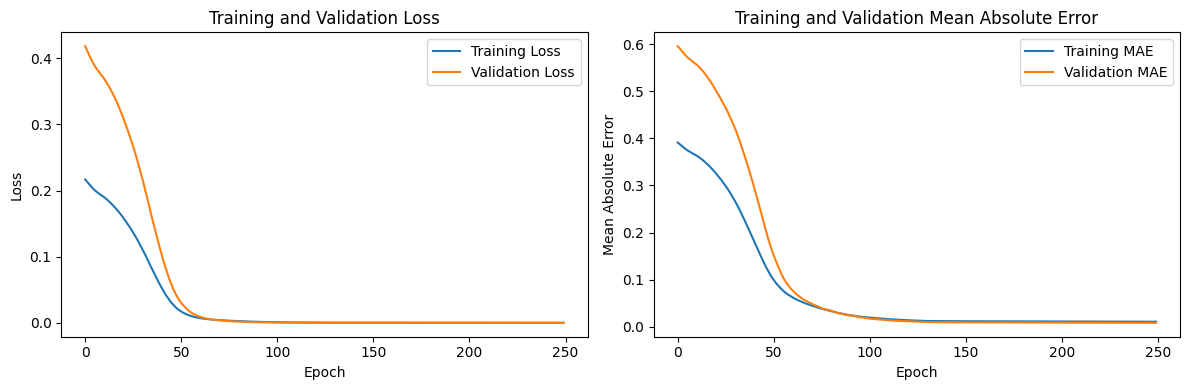

Best Validation Loss: 0.0001 at epoch 250
Best Training Loss: 0.0003 at epoch 250


<Figure size 1200x2400 with 0 Axes>

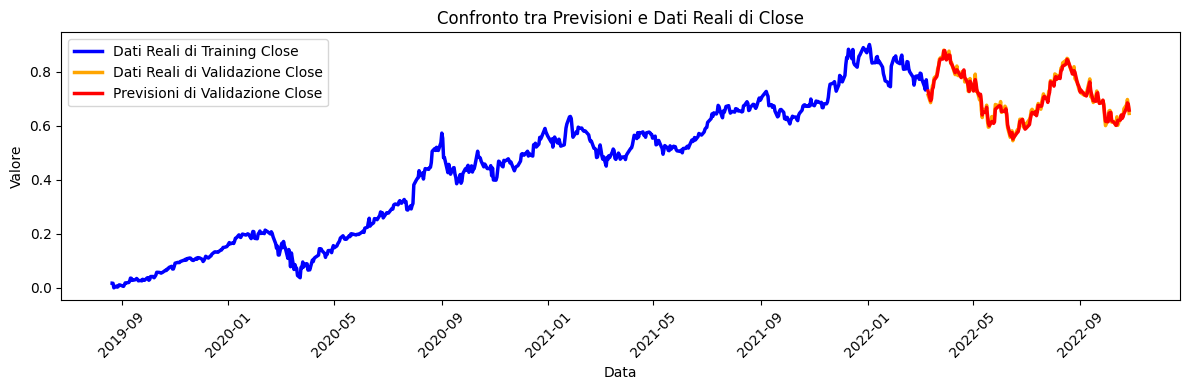

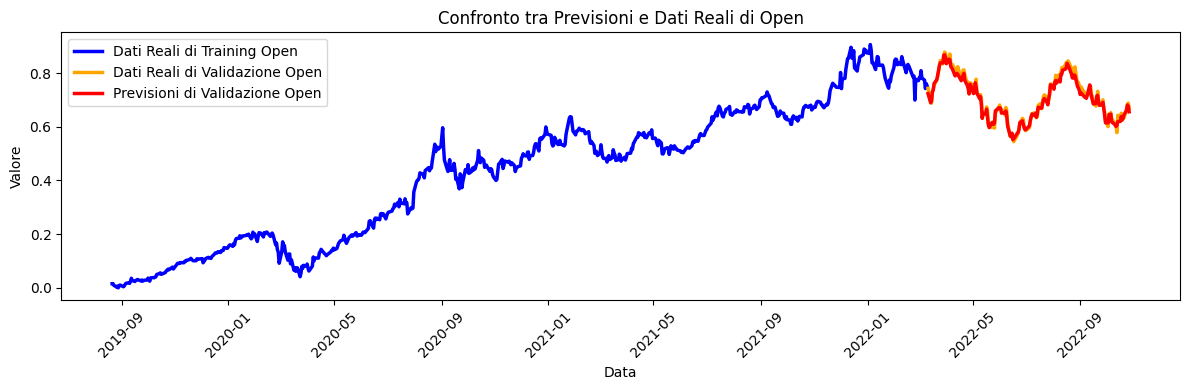

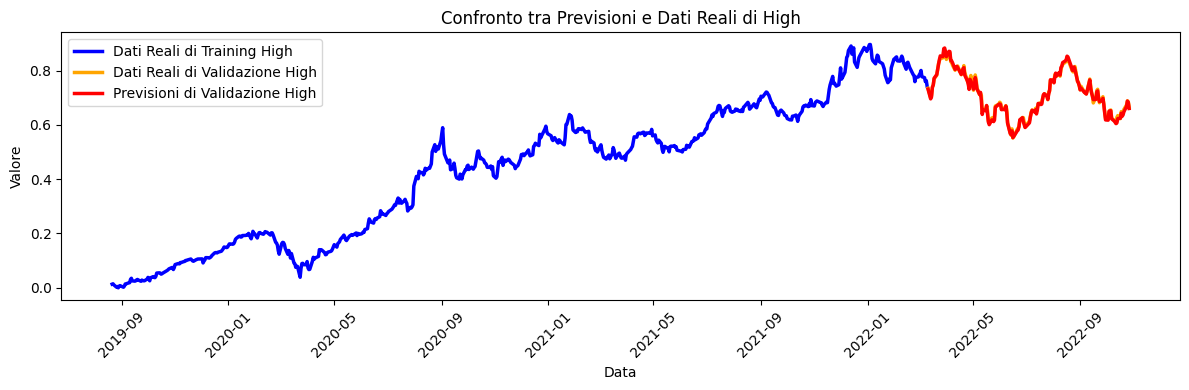

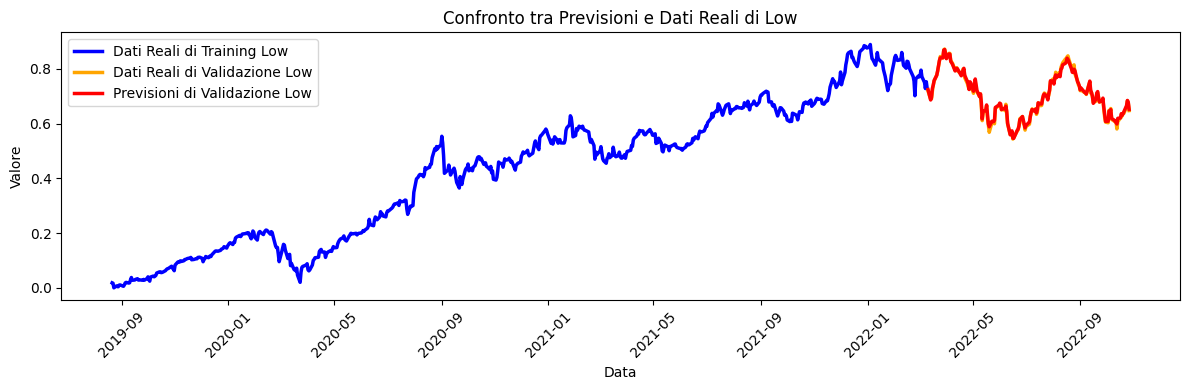

     Actual Close  Actual Open  Actual High  Actual Low  Actual Volume
0        0.713835     0.743071     0.734673    0.718817       0.165831
1        0.685644     0.691561     0.699523    0.688478       0.195604
2        0.716304     0.687773     0.709401    0.690409       0.155691
3        0.747171     0.730124     0.739578    0.718541       0.179323
4        0.754236     0.740867     0.746390    0.740399       0.111776
..            ...          ...          ...         ...            ...
155      0.662666     0.632476     0.656812    0.637110       0.139451
156      0.677618     0.662225     0.673025    0.660208       0.112703
157      0.697442     0.682195     0.688420    0.683376       0.109540
158      0.676933     0.688187     0.685014    0.674274       0.143617
159      0.645723     0.668285     0.664986    0.647314       0.196739

[160 rows x 5 columns]
     Prediction Close  Prediction Open  Prediction High  Prediction Low  \
0            0.728619         0.723267         0.

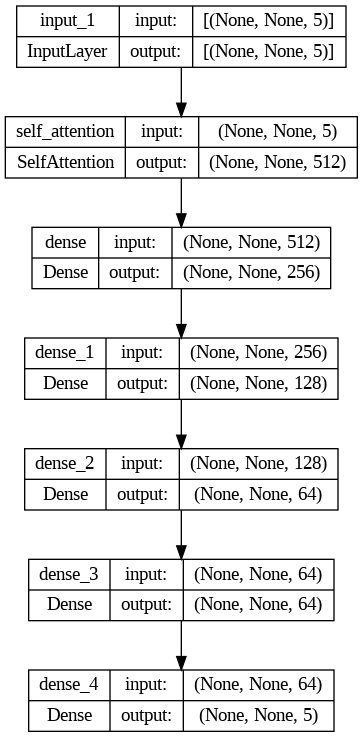

In [ ]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Layer, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import GlobalAveragePooling1D
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Definizione della funzione per convertire una stringa in un oggetto datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

# Caricamento dei dati dai file CSV
df = pd.read_csv('AAPL.csv')
#df = pd.read_csv('AMZN.csv')
#df = pd.read_csv('GOOG.csv')
#df = pd.read_csv('MSFT.csv')

# Selezione delle colonne di interesse (Date, Close, Open, High, Low, Volume)
df = df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']]

# Conversione delle date da stringa a oggetti datetime
df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')

# Rimozione delle righe con dati mancanti o nulli
df.dropna(inplace=True)

# Normalizzazione dei dati utilizzando la tecnica Min-Max
scaler = MinMaxScaler()
df[['Close', 'Open', 'High', 'Low', 'Volume']] = scaler.fit_transform(df[['Close', 'Open', 'High', 'Low', 'Volume']])

# Creazione di input (X) e target (y) dai dati
X = df[['Close', 'Open', 'High', 'Low', 'Volume']].values
y = df[['Close', 'Open', 'High', 'Low', 'Volume']].values  # Target multi-output

# Calcolo delle dimensioni dei set
train_size = int(len(X) * 0.8)
val_size = int(train_size * 0.2)  # 20% del training set

# Divisione dei dati in set di addestramento, validazione e test
X_train, y_train = X[:train_size - val_size], y[:train_size - val_size]
X_val, y_val = X[train_size - val_size:train_size], y[train_size - val_size:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train_3d = X_train[:, np.newaxis, :]  # (1006, 1, 5)
X_val_3d = X_val[:, np.newaxis, :]  # (dimensioni_val, 1, 5)
X_test_3d = X_test[:, np.newaxis, :]  # (dimensioni_test, 1, 5)

# Aggiungi una dimensione temporale anche per i target
y_train_3d = y_train[:, np.newaxis, :]
y_val_3d = y_val[:, np.newaxis, :]
y_test_3d = y_test[:, np.newaxis, :]

# Definizione dello strato di Self-Attention
class SelfAttention(Layer):
    def __init__(self, num_heads, head_dim, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.head_dim = head_dim

    def build(self, input_shape):
        self.W_q = self.add_weight("W_q", shape=(input_shape[-1], self.num_heads * self.head_dim))
        self.W_k = self.add_weight("W_k", shape=(input_shape[-1], self.num_heads * self.head_dim))
        self.W_v = self.add_weight("W_v", shape=(input_shape[-1], self.num_heads * self.head_dim))

    def call(self, inputs):
        q = tf.matmul(inputs, self.W_q)
        k = tf.matmul(inputs, self.W_k)
        v = tf.matmul(inputs, self.W_v)

        q = tf.reshape(q, (-1, tf.shape(q)[1], self.num_heads, self.head_dim))
        k = tf.reshape(k, (-1, tf.shape(k)[1], self.num_heads, self.head_dim))
        v = tf.reshape(v, (-1, tf.shape(v)[1], self.num_heads, self.head_dim))

        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)

        output = tf.matmul(attention_scores, v)
        output = tf.reshape(output, (-1, tf.shape(output)[1], self.num_heads * self.head_dim))

        return output

# Dimensioni dei dati
num_features = 5  # Numero di features nel dataset
num_heads = 8     # Numero di teste per l'attenzione multi-head
head_dim = 64     # Dimensione di ogni testa di attenzione

# Creazione del modello Sequential
transformer_model = Sequential()

# Aggiunta degli strati al modello
transformer_model.add(Input(shape=(None, 5)))  # Adatta la forma all'intero dataset
transformer_model.add(SelfAttention(num_heads=num_heads, head_dim=head_dim))
transformer_model.add(Dense(256, activation='relu'))
transformer_model.add(Dense(128, activation='relu'))
transformer_model.add(Dense(64, activation='relu'))
transformer_model.add(Dense(64, activation='relu'))
transformer_model.add(Dense(num_features))


# Creazione del modello con self-attention e più strati
transformer_model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.00001),
              metrics=['mean_absolute_error'])

# Stampa un riassunto del modello
transformer_model.summary()

# Aggiunta di un callback per ridurre il tasso di apprendimento su plateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, verbose=1, min_lr=1e-6)
callbacks = [lr_scheduler]

history = transformer_model.fit(X_train_3d, y_train_3d, validation_data=(X_val_3d, y_val_3d),
                                      epochs=250,
                                      batch_size=64,
                                      callbacks=callbacks,
                                      verbose=1)


# Creazione delle previsioni sui dati di validazione e test
predictions_val = transformer_model.predict(X_val_3d)
predictions_test = transformer_model.predict(X_test_3d)

# Valuta il modello sull'insieme di test
test_loss, test_mae = transformer_model.evaluate(X_test_3d, y_test_3d, verbose=0)

# Riduci le dimensioni di y_test_3d a (1006, 5)
y_test_2d = y_test_3d.reshape(-1, 5)

# Rimuovi il terzo asse dalle previsioni
predictions_test_squeezed = np.squeeze(predictions_test)

# Calcola il RMSE
rmse = np.sqrt(mean_squared_error(y_test_2d, predictions_test_squeezed))

# Calcola il R-squared (R²)
r2 = r2_score(y_test_2d, predictions_test_squeezed)

print(f'Test Loss: {test_loss}')
print(f'Test Mean Absolute Error (MAE): {test_mae}')
print(f'Test Root Mean Squared Error (RMSE): {rmse}')
print(f'Test R-squared (R²): {r2}')


# Creazione dei grafici delle learning curve
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation Mean Absolute Error')

plt.tight_layout()
plt.show()

# Trova l'indice dell'epoca con la minima val_loss e loss
best_epoch_val = np.argmin(history.history['val_loss'])
best_epoch = np.argmin(history.history['loss'])
# Trova il valore minimo della val_loss e loss
best_val_loss = history.history['val_loss'][best_epoch_val]
best_loss = history.history['loss'][best_epoch]
# Stampa il risultato
print(f'Best Validation Loss: {best_val_loss:.4f} at epoch {best_epoch_val + 1}')
print(f'Best Training Loss: {best_loss:.4f} at epoch {best_epoch + 1}')


feature_names = ['Close', 'Open', 'High', 'Low']  # Escludi la feature 'Volume'

plt.figure(figsize=(12, 24))  # Imposta la dimensione complessiva del grafico

total_train_samples = len(y_train)
total_val_samples = len(y_val)

# Estrai le date dei dati di addestramento e validazione
dates_train = df.index[:total_train_samples]
dates_val = df.index[total_train_samples:total_train_samples + total_val_samples]

# Creazione dei grafici delle previsioni per ciascuna feature
for feature_index, feature_name in enumerate(feature_names):
    plt.figure(figsize=(12, 4))

    # Estrai i dati reali e le previsioni per la caratteristica specifica
    y_train_feature = y_train_3d[:, 0, feature_index]
    y_val_feature = y_val_3d[:, 0, feature_index]
    predictions_val_feature = predictions_val[:, 0, feature_index]

    plt.plot(dates_train, y_train_feature, color='blue', label=f'Dati Reali di Training {feature_name}', linewidth=2.5)
    plt.plot(dates_val, y_val_feature, color='orange', label=f'Dati Reali di Validazione {feature_name}', linewidth=2.5)
    plt.plot(dates_val, predictions_val_feature, color='red', label=f'Previsioni di Validazione {feature_name}', linewidth=2.5)

    plt.xlabel('Data')
    plt.ylabel('Valore')
    plt.title(f'Confronto tra Previsioni e Dati Reali di {feature_name}')
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Crea un DataFrame da y_val con nomi di colonne appropriati
y_val_df = pd.DataFrame(y_val_3d[:, 0, :], columns=['Actual Close', 'Actual Open', 'Actual High', 'Actual Low', 'Actual Volume'])
print(y_val_df)
# Crea un nuovo DataFrame con le colonne di previsione
predictions_val_df = pd.DataFrame(predictions_val[:, 0, :], columns=['Prediction Close', 'Prediction Open', 'Prediction High', 'Prediction Low', 'Prediction Volume'])
print(predictions_val_df)
# Unisci i due DataFrame in uno solo
combined_df = pd.concat([y_val_df, predictions_val_df], axis=1)

# Stampa il DataFrame risultante
#print(combined_df)

#--------------------stampare un grafico del modello-------------------------------------------------
plot_model(transformer_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Stampa le dimensioni degli array
#X_train_3d, y_train_3d, validation_data=(X_val_3d, y_val_3d)
print("Dimensioni X_train:", X_train_3d.shape)
print("Dimensioni y_train:", y_train_3d.shape)
print("Dimensioni X_train:", X_train.shape)
print("Dimensioni y_train:", y_train.shape)
print("Dimensioni X_val:", X_val_3d.shape)
print("Dimensioni y_val:", y_val_3d.shape)
print("Dimensioni X_test:", X_test.shape)
print("Dimensioni y_test:", y_test.shape)
print(predictions_val.shape)
print(predictions_test.shape)


Dimensioni X_train: (644, 1, 5)
Dimensioni y_train: (644, 1, 5)
Dimensioni X_train: (644, 5)
Dimensioni y_train: (644, 5)
Dimensioni X_val: (160, 1, 5)
Dimensioni y_val: (160, 1, 5)
Dimensioni X_test: (202, 5)
Dimensioni y_test: (202, 5)
(160, 1, 5)
(202, 1, 5)


In [ ]:
# Numero di features
num_features = predictions_val.shape[2]

for i in range(num_features):
    feature_name = feature_names[i]
    first_10_predictions = predictions_val[:10, 0, i]  # Considerando il time step 0
    print(f"Primi 10 valori di predizione per la feature '{feature_name}':")
    print(first_10_predictions)
    print()


Primi 10 valori di predizione per la feature 'Close':
[0.43651238 0.43335143 0.43247002 0.43807635 0.43649563 0.44526377
 0.4438982  0.44445914 0.44879347 0.45056012]

Primi 10 valori di predizione per la feature 'Open':
[0.38470736 0.38186333 0.3810701  0.3861149  0.3846925  0.39258242
 0.39135355 0.3918581  0.39575857 0.39734825]

Primi 10 valori di predizione per la feature 'High':
[0.3444281  0.34197536 0.34129146 0.34564188 0.34441522 0.35121912
 0.35015953 0.35059452 0.3539582  0.35532913]

Primi 10 valori di predizione per la feature 'Low':
[0.40678695 0.40384448 0.4030239  0.40824306 0.40677148 0.41493404
 0.4136628  0.41418484 0.41822004 0.4198647 ]



IndexError: ignored

In [ ]:
# Creazione delle previsioni sui primi 10 giorni dei dati di test
predictions_first_10 = model.predict(X_test[:10, np.newaxis, :])

# Estrazione delle feature names
feature_names = ['Close', 'Open', 'High', 'Low', 'Volume']

# Creazione di un array per memorizzare i risultati delle predizioni
results_array = []

# Ciclo per ottenere gli array dei risultati delle predizioni per le prime 10 giornate
for i, feature in enumerate(feature_names):
    real_data = y_test[:10, i]
    predicted_data = predictions_first_10[:, 0, i]
    results_array.append({
        'Feature': feature,
        'Real Data': real_data,
        'Predicted Data': predicted_data
    })

1/1 [==============================] - 0s 23ms/step
